## RNN Iteration 4

### Import the required packages

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, SimpleRNN, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam

### Load the dataset

In [4]:
file_path = 'processed_dataset_v4.csv'
df = pd.read_csv(file_path)

In [4]:
df.head()

,Tokens,POS_Tags_new,Sentiment_Score_new,GloVe_Embedding_new,sentence,emotion
0,"['sofia', '.', 'lilyana', 'georgieva', 'and', ...","['PROPN', 'PUNCT', 'PROPN', 'PROPN', 'CCONJ', ...",0.0000,"[0.027128880843520164, 0.1339159458875656, 0.0...",Sofia. Lilyana Georgieva and her 13-year-elder...,neutral
1,"['ever', 'since', 'velina', ""'s"", 'father', 'a...","['ADV', 'SCONJ', 'PROPN', 'PART', 'NOUN', 'VER...",-0.4588,"[0.028150998055934906, 0.11559371650218964, -0...",Ever since Velina's father abandoned her relat...,sadness
2,"['velina', 'has', 'a', 'very', 'tough', 'time'...","['PROPN', 'VERB', 'DET', 'ADV', 'ADJ', 'NOUN',...",-0.2492,"[0.03733610361814499, 0.18700453639030457, -0....",Velina has a very tough time to construct a st...,sadness
3,"['she', 'suffered', 'a', 'lot', ',', 'crying',...","['PRON', 'VERB', 'DET', 'NOUN', 'PUNCT', 'VERB...",-0.7430,"[-0.05386895313858986, 0.22456040978431702, -0...","She suffered a lot, crying a lot. I somehow wa...",sadness
4,"['so', 'i', 'allowed', 'myself', 'to', 'buy', ...","['ADV', 'PRON', 'VERB', 'PRON', 'PART', 'VERB'...",0.0000,"[0.04465412721037865, 0.1614578664302826, -0.2...",So I allowed myself to buy her whatever she wa...,sadness


### Downsample the classes with most data points - (Happinness and Sadness)

In [ ]:
# Define target undersampled sizes
target_sizes = {
    "happiness": 100_000,
    "sadness": 80_000
}

# Separate out the DataFrame per emotion
dfs = []
# for loop to iterate through the unique emotions in the DataFrame
for emotion in df["emotion"].unique():
    subset = df[df["emotion"] == emotion]
    # check if the current emotion is in the target sizes
    if emotion in target_sizes:
        # Undersample with random_state for reproducibility
        subset = subset.sample(n=target_sizes[emotion], random_state=42)
    
    dfs.append(subset)

# Combine back all subsets
balanced_df = pd.concat(dfs).reset_index(drop=True)

# Shuffle the final DataFrame
df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print("New class distribution:\n", df["emotion"].value_counts())

New class distribution:
 emotion
happiness    100000
sadness       80000
anger         67255
fear          49018
neutral       32967
surprise      23633
disgust        6549
Name: count, dtype: int64


### Pre-Process the Tokens with max length for padding set to 32

In [ ]:
import ast
#  Safe converter for Tokens column 
def safe_tokens_to_str(x):
    if isinstance(x, str):
        try:
            x = ast.literal_eval(x)  # Convert stringified list to real list
        except:
            return ""
    if isinstance(x, list):
        return ' '.join(x)  # Join list to space-separated string
    return ""

# Apply clean conversion 
df['Tokens_str'] = df['Tokens'].apply(safe_tokens_to_str)

# Tokenization 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Tokens_str'])
sequences = tokenizer.texts_to_sequences(df['Tokens_str'])

# Padding
max_len = 32
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

### Check the length of words distribution

In [ ]:
import ast

df["Tokens"] = df["Tokens"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df["seq_len"] = df["Tokens"].apply(len)

# Summary statistics
print("🔍 Sequence length stats:")
print(df["seq_len"].describe())


🔍 Sequence length stats:
count    476985.000000
mean         18.460090
std          10.691697
min           0.000000
25%          10.000000
50%          16.000000
75%          24.000000
max         179.000000
Name: seq_len, dtype: float64


### Pre-Process the Pos Tags

In [ ]:
# encode the labels
df['POS_Tags_new'] = df['POS_Tags_new'].apply(lambda x: eval(x) if isinstance(x, str) else x)
# flatten the list of lists to get all unique tags
all_tags = [tag for seq in df['POS_Tags_new'] for tag in seq]
# initialize the label encoder and fit it on the unique tags
le_pos = LabelEncoder()
le_pos.fit(all_tags)
# create a new column with the encoded labels
df['POS_Encoded'] = df['POS_Tags_new'].apply(lambda tags: le_pos.transform(tags))
pos_padded = pad_sequences(df['POS_Encoded'], maxlen=max_len, padding='post')

### Pre-Process the Sentiment Score

In [ ]:
# initialize the one-hot encoder
scaler = StandardScaler()
sentiment_scaled = scaler.fit_transform(df[['Sentiment_Score_new']])

### Pre-Process the Glove Embeddings (Sentence Averaged)

In [ ]:
# PreProcess GloVe embeddings
df['GloVe_Embedding_new'] = df['GloVe_Embedding_new'].apply(lambda x: np.array(eval(x)) if isinstance(x, str) else np.zeros(300))
# Vstack the GloVe embeddings
glove_features = np.vstack(df['GloVe_Embedding_new'].values)

### Pre-Process the labels using label encoder

In [ ]:
# initialize label encoder
label_encoder = LabelEncoder()
# fit the label encoder on the unique labels
int_labels = label_encoder.fit_transform(df['emotion'])
# convert the labels to a one-hot encoded format
onehot_encoder = OneHotEncoder(sparse_output=False)
labels = onehot_encoder.fit_transform(int_labels.reshape(-1, 1))

### Train/Val split the dataset and the feature to prepare for training

In [ ]:
# Define the input features and labels
X_text = padded_sequences
X_pos = pos_padded
X_sentiment = sentiment_scaled
X_glove = glove_features
y = labels


# Set validation split percentage
val_size = 0.2  # 20% of the data for validation

# Perform train-validation split
X_train_text, X_val_text, \
X_train_pos, X_val_pos, \
X_train_sent, X_val_sent, \
X_train_glove, X_val_glove, \
y_train, y_val = train_test_split(
    X_text, X_pos, X_sentiment, X_glove, y,
    test_size=val_size, random_state=42, stratify=y
)

# Print dataset sizes
print(f"Train Samples: {len(X_train_text)}")
print(f"Validation Samples: {len(X_val_text)}")


📊 Train Samples: 381588
📊 Validation Samples: 95397


### Define class-weights, so there is more attention to the less represented classes

In [8]:
#  Get label counts again
class_counts = {
    "happiness": 168071,
    "sadness": 129437,
    "anger": 67216,
    "fear": 49008,
    "neutral": 28223,
    "surprise": 19525,
    "disgust": 1750,  
}

# Compute initial class weights
total_samples = sum(class_counts.values())
class_weights = {label: total_samples / (len(class_counts) * count) for label, count in class_counts.items()}

# Fine-Tune Class-Weights Manually
class_weights["disgust"] *= 0.8   
class_weights["happiness"] *= 1.2  
class_weights["sadness"] *= 1.15   
class_weights["anger"] *= 1.1      
class_weights["neutral"] *= 1.0    
class_weights["surprise"] *= 1.0  
class_weights["fear"] *= 1.0       

# Convert to Keras format
label_encoder = LabelEncoder()
# Fit the label encoder on the unique labels
int_labels = label_encoder.fit_transform(list(class_counts.keys()))
class_weight_dict = {int_labels[i]: class_weights[label] for i, label in enumerate(class_counts.keys())}

print("Adjusted Class Weights:", class_weight_dict)

Adjusted Class Weights: {3: 0.4724839927343631, 5: 0.5879468114107359, 0: 1.0829755670418608, 2: 1.3503043234923744, 4: 2.3447441549698573, 6: 3.3892811413938175, 1: 30.251755102040818}


### Define the model architecture

In [ ]:
# INPUTS 
max_len = X_train_text.shape[1]
vocab_size = len(tokenizer.word_index) + 1
pos_vocab_size = len(le_pos.classes_) + 1
n_classes = y_train.shape[1]

# Text input (Tokens)
text_input = Input(shape=(max_len,), name='text_input')
text_emb = Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len, mask_zero=True)(text_input) # Embedding layer to convert words to vectors with mask_zero set to True
text_rnn = Bidirectional(SimpleRNN(64, return_sequences=False))(text_emb) # Bidirectional RNN layer to process the sequence of word vectors

# POS input
pos_input = Input(shape=(max_len,), name='pos_input')
pos_emb = Embedding(input_dim=pos_vocab_size, output_dim=16, input_length=max_len, mask_zero=True)(pos_input)# Embedding layer to convert POS tags to vectors with mask_zero set to True
pos_rnn = Bidirectional(SimpleRNN(32, return_sequences=False))(pos_emb) # Bidirectional RNN layer to process the sequence of POS tag vectors

# Sentiment input
sentiment_input = Input(shape=(1,), name='sentiment_input') # Input layer for sentiment score
sent_dense = Dense(16, activation='relu')(sentiment_input) # Dense layer to process the sentiment score

# GloVe input (sentence embedding)
glove_input = Input(shape=(300,), name='glove_input') # Input Layer for the GloVe Embeddings
glove_dense = Dense(64, activation='relu')(glove_input)

# Concatenate all inputs
merged = Concatenate()([text_rnn, pos_rnn, sent_dense, glove_dense])
x = Dense(128, activation='relu')(merged) # Dense layer to process the concatenated features
x = Dropout(0.4)(x) # Dropout layer to prevent overfitting
x = Dense(64, activation='relu')(x) # Dense layer to further process the features
output = Dense(n_classes, activation='softmax')(x) # Output layer with softmax activation for multi-class classification

# initialize the model
model = Model(inputs=[text_input, pos_input, sentiment_input, glove_input], outputs=output)
# print the model summary
model.summary()

C:\Users\vl4di\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pos_input           │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 32, 128)   │ 10,429,440 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 32)        │          0 │ text_input[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 32, 16)    │        304 │ pos_input[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 32)        │          0 │ pos_input[0][0]   │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sentiment_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ glove_input         │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128)       │     24,704 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 64)        │      3,136 │ embedding_1[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │         32 │ sentiment_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     19,264 │ glove_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 272)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional_1[… │
│                     │                   │            │ dense[0][0],      │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     34,944 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 7)         │        455 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,520,535 (40.13 MB)

 Trainable params: 10,520,535 (40.13 MB)

 Non-trainable params: 0 (0.00 B)

### Define the f1-score the model is going to be evaluated

In [ ]:
import tensorflow.keras.backend as K
import tensorflow as tf
# define custom metrics
def f1_micro(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)
    # Calculate precision and recall
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    # Calculate F1 score
    f1 = 2 * precision * recall / (precision + recall + K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

### Compile the model and train it on the features

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', f1_micro])
# fit the model and store the training history
history = model.fit(
    x={
        'text_input': X_train_text, # input for text data
        'pos_input': X_train_pos, # input for POS tags
        'sentiment_input': X_train_sent, # input for sentiment score
        'glove_input': X_train_glove # input for Word2Vec embeddings
    },
    y=y_train, # target labels
    # validation data for evaluation during training
    validation_data=(
        {
            'text_input': X_val_text,
            'pos_input': X_val_pos,
            'sentiment_input': X_val_sent,
            'glove_input': X_val_glove
        },
        y_val
    ),
    # define batch size and number of epochs
    batch_size=64,
    epochs=10,
    # use class weights to handle class imbalance
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/10
5963/5963 ━━━━━━━━━━━━━━━━━━━━ 564s 93ms/step - accuracy: 0.6502 - f1_micro: 0.4939 - loss: 1.1260 - val_accuracy: 0.8148 - val_f1_micro: 0.7088 - val_loss: 0.5240
Epoch 2/10
5963/5963 ━━━━━━━━━━━━━━━━━━━━ 572s 96ms/step - accuracy: 0.8134 - f1_micro: 0.7107 - loss: 0.6274 - val_accuracy: 0.8004 - val_f1_micro: 0.6926 - val_loss: 0.5836
Epoch 3/10
5963/5963 ━━━━━━━━━━━━━━━━━━━━ 609s 102ms/step - accuracy: 0.8229 - f1_micro: 0.7231 - loss: 0.5701 - val_accuracy: 0.8083 - val_f1_micro: 0.6968 - val_loss: 0.5313
Epoch 4/10
5963/5963 ━━━━━━━━━━━━━━━━━━━━ 577s 97ms/step - accuracy: 0.8412 - f1_micro: 0.7476 - loss: 0.4810 - val_accuracy: 0.8200 - val_f1_micro: 0.7067 - val_loss: 0.5059
Epoch 5/10
5963/5963 ━━━━━━━━━━━━━━━━━━━━ 506s 85ms/step - accuracy: 0.8504 - f1_micro: 0.7624 - loss: 0.4379 - val_accuracy: 0.8244 - val_f1_micro: 0.7042 - val_loss: 0.5014
Epoch 6/10
5963/5963 ━━━━━━━━━━━━━━━━━━━━ 486s 82ms/step - accuracy: 0.8547 - f1_micro: 0.7675 - loss: 0.4142 - val_accuracy

### Save the model

In [18]:
model.save("emotion_rnn_model_v9.h5")

In [19]:
model.save("emotion_model_v9.keras", save_format="keras")


### Plot the model learning curves

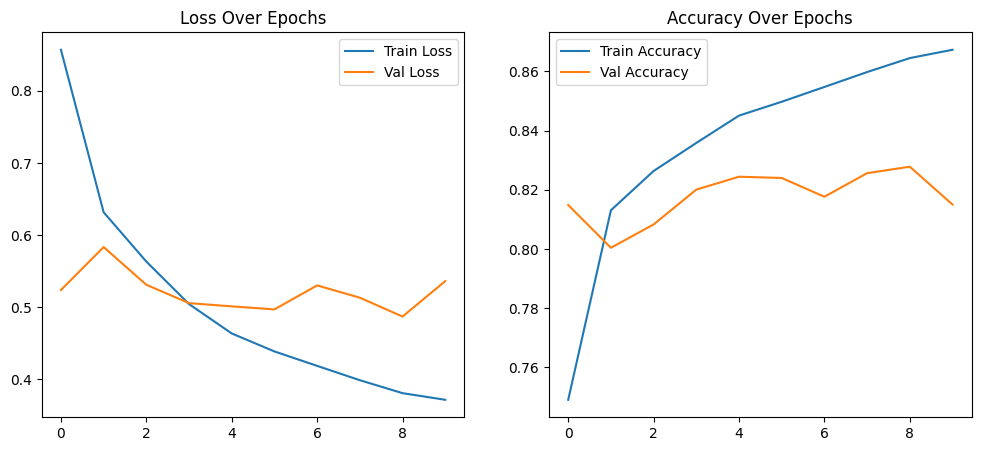

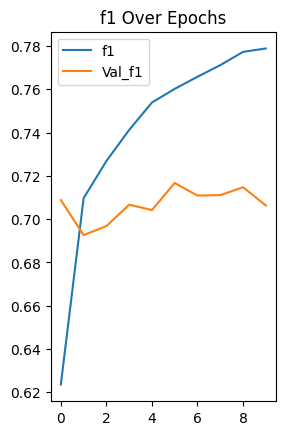

In [ ]:
# Plot Training History
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
# plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy Over Epochs")
plt.show()
# plot f1 score
plt.subplot(1, 2, 2)
plt.plot(history.history['f1_micro'], label='f1')
plt.plot(history.history['val_f1_micro'], label='Val_f1')
plt.legend()
plt.title("f1 Over Epochs")
plt.show()

### Plot bar plot to see per-class Recall (Prediction Rate)

2982/2982 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step


C:\Users\vl4di\AppData\Local\Temp\ipykernel_48172\2752300191.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(recalls.keys()), y=list(recalls.values()), palette="Set2")


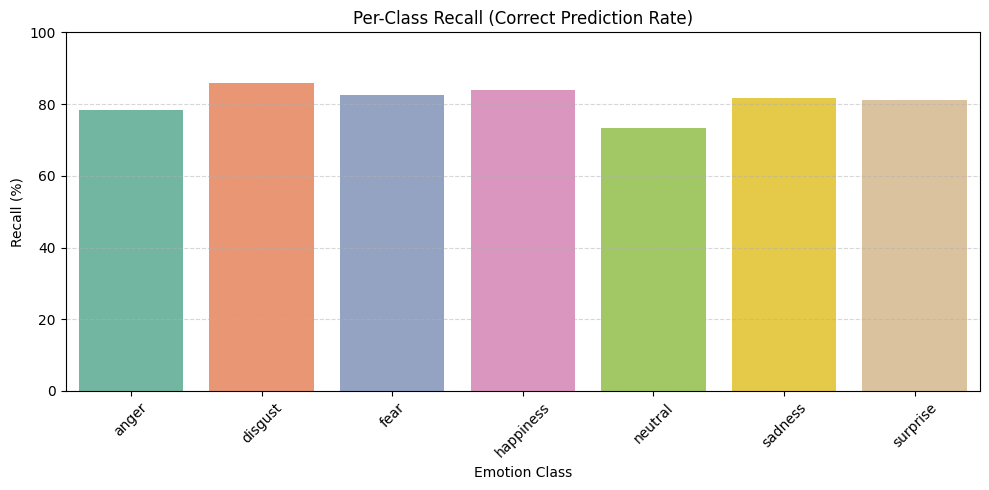

In [ ]:
import seaborn as sns
# Get true and predicted labels 
y_pred_probs = model.predict({
    'text_input': X_val_text,
    'pos_input': X_val_pos,
    'sentiment_input': X_val_sent,
    'glove_input': X_val_glove
})

y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)

#  Get per-class recall from classification report 
from sklearn.metrics import classification_report

target_names = label_encoder.classes_
report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
recalls = {label: round(metrics["recall"] * 100, 2) for label, metrics in report.items() if label in target_names}

# Plot 
plt.figure(figsize=(10, 5))
sns.barplot(x=list(recalls.keys()), y=list(recalls.values()), palette="Set2")
plt.ylabel("Recall (%)")
plt.xlabel("Emotion Class")
plt.title("Per-Class Recall (Correct Prediction Rate)")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Print Per-Class Recall

In [22]:
print("📊 Per-Class Recall (Correct Prediction Rate):\n")
for emotion, recall in recalls.items():
    print(f"{emotion:<10}: {recall:.2f}%")


📊 Per-Class Recall (Correct Prediction Rate):

anger     : 78.45%
disgust   : 85.80%
fear      : 82.59%
happiness : 83.83%
neutral   : 73.21%
sadness   : 81.60%
surprise  : 81.21%


### Plot Confusion Matrix of Recall % per Class

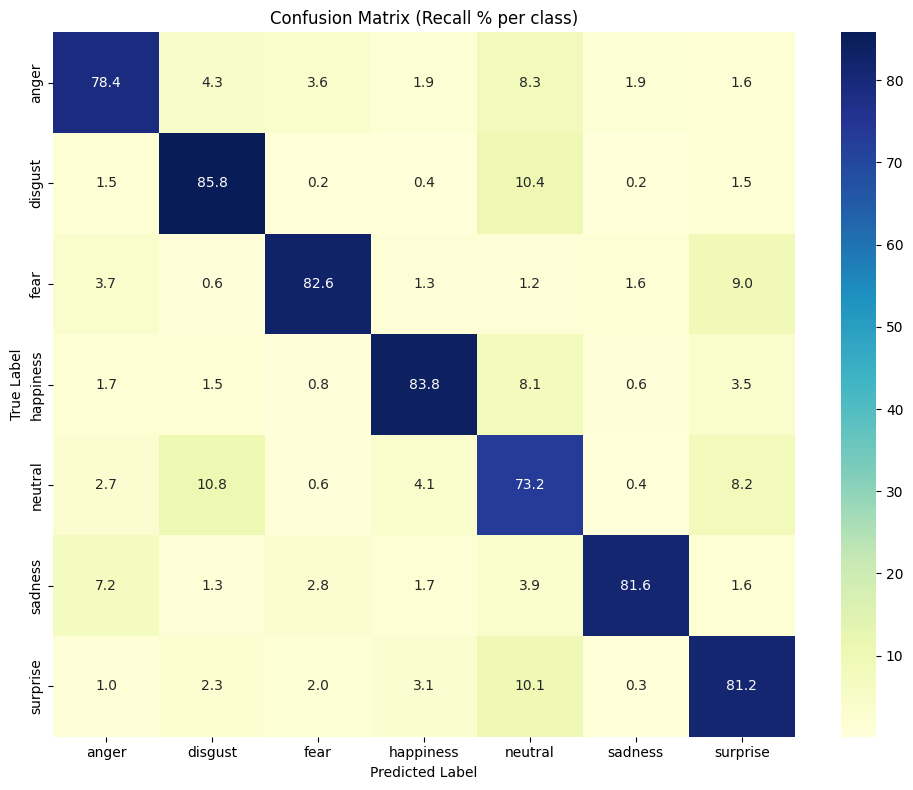

In [ ]:
from sklearn.metrics import confusion_matrix

# Prepare true and predicted labels 
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)
labels = label_encoder.classes_

# Compute confusion matrix 
cm = confusion_matrix(y_true, y_pred)

# Normalize to percentages (optional but helpful) 
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot 
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="YlGnBu", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix (Recall % per class)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()